In [1]:
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from pathlib import Path
from datasets import Dataset, DatasetDict
from datasets import concatenate_datasets
from transformers import DistilBertForSequenceClassification

In [2]:
dataset = os.getcwd()

In [3]:
datasetfolder = dataset + "\Datasets\SpamDataset"

In [4]:
dataset = datasetfolder + "\spam.csv"

In [5]:
dataset

'C:\\Projects\\ScamDetector\\Model\\Datasets\\SpamDataset\\spam.csv'

In [6]:
df = pd.read_csv(dataset, encoding='latin1')

In [7]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
df.drop(df.columns[[2,3,4]], axis=1, inplace=True)

In [9]:
df.columns = ['label', 'sms']

In [10]:
df

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
def spamtoham(x):
    if (x == 'spam'):
        return 1
    if (x== 'ham'):
        return 0
    

In [12]:
df['label'] = df['label'].apply(spamtoham)

In [13]:
df

,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [14]:
df.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [15]:
df.groupby('label').describe()

sms                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

C:\Users\15148\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

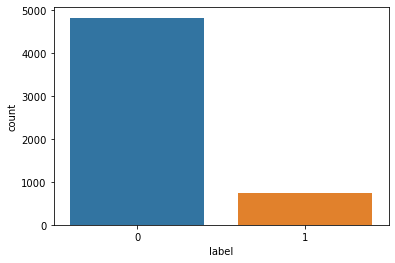

In [16]:
sb.countplot(df.label)

In [17]:
train, test = train_test_split(df, test_size=0.2, random_state=11, shuffle=True)

In [18]:
train_sms = train['sms'].values
train_labels = train['label'].values

test_sms = test['sms'].values
test_labels = test['label'].values

In [19]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [20]:
train_tokenized = tokenizer(list(train_sms), truncation = True, padding = True)
test_tokenized = tokenizer(list(test_sms), truncation = True, padding = True)

In [21]:
train_tokenized[0]

Encoding(num_tokens=238, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [22]:
class ScamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item
   
    def __len__(self):
        return len(self.labels)

train_dataset = ScamDataset(train_tokenized, train_labels)
test_dataset = ScamDataset(test_tokenized, test_labels)
    

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [24]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [25]:
DEVICE

device(type='cuda', index=0)

In [26]:
torch.cuda.device_count()

1

In [27]:
torch.cuda.is_available()

True

In [28]:
torch.__version__

'2.1.2+cu121'

In [29]:
train_loader

In [30]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model.to(DEVICE)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr= 2e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [31]:
#Compute accuracy
def accuracy(model, data_loader, device):
    with torch.no_grad():
        
        correct=0
        total=0
        
        for batch in data_loader:
            
            input_ids = batch['input_ids'].to(DEVICE)
            attention_masks = batch['attention_mask'].to(DEVICE)
            label = batch['label'].to(DEVICE)
            
            outputs = model(input_ids, attention_masks, labels = label)
            loss, logits = outputs['loss'], outputs['logits']
            _, predicted_labels = torch.max(logits, 1)
                
            
            total += label.size(0)
            correct += (predicted_labels == label).sum()
    
    return correct/total *100
            
            

In [32]:
epochs = 1

In [33]:
start_time = time.time()
for epoch in range (epochs):
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        
        
        input_ids = batch['input_ids'].to(DEVICE)
        attention_masks = batch['attention_mask'].to(DEVICE)
        label = batch['label'].to(DEVICE)
        
        outputs = model(input_ids, attention_masks, labels = label)
        loss, logits = outputs['loss'], outputs['logits']
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print (f'Epoch: {epoch+1:04d}/{epochs:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')
            
    model.eval()

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{accuracy(model, train_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {accuracy(model, test_loader, DEVICE):.2f}%')
        
        

Epoch: 0001/0001 | Batch 0000/0279 | Loss: 0.6790
Epoch: 0001/0001 | Batch 0001/0279 | Loss: 0.6575
Epoch: 0001/0001 | Batch 0002/0279 | Loss: 0.5981
Epoch: 0001/0001 | Batch 0003/0279 | Loss: 0.5582
Epoch: 0001/0001 | Batch 0004/0279 | Loss: 0.4990
Epoch: 0001/0001 | Batch 0005/0279 | Loss: 0.5426
Epoch: 0001/0001 | Batch 0006/0279 | Loss: 0.4273
Epoch: 0001/0001 | Batch 0007/0279 | Loss: 0.5295
Epoch: 0001/0001 | Batch 0008/0279 | Loss: 0.3737
Epoch: 0001/0001 | Batch 0009/0279 | Loss: 0.3708
Epoch: 0001/0001 | Batch 0010/0279 | Loss: 0.2252
Epoch: 0001/0001 | Batch 0011/0279 | Loss: 0.3540
Epoch: 0001/0001 | Batch 0012/0279 | Loss: 0.2392
Epoch: 0001/0001 | Batch 0013/0279 | Loss: 0.2552
Epoch: 0001/0001 | Batch 0014/0279 | Loss: 0.3226
Epoch: 0001/0001 | Batch 0015/0279 | Loss: 0.2488
Epoch: 0001/0001 | Batch 0016/0279 | Loss: 0.5553
Epoch: 0001/0001 | Batch 0017/0279 | Loss: 0.1850
Epoch: 0001/0001 | Batch 0018/0279 | Loss: 0.3547
Epoch: 0001/0001 | Batch 0019/0279 | Loss: 0.2311


Epoch: 0001/0001 | Batch 0164/0279 | Loss: 0.0299
Epoch: 0001/0001 | Batch 0165/0279 | Loss: 0.0272
Epoch: 0001/0001 | Batch 0166/0279 | Loss: 0.0142
Epoch: 0001/0001 | Batch 0167/0279 | Loss: 0.0479
Epoch: 0001/0001 | Batch 0168/0279 | Loss: 0.0151
Epoch: 0001/0001 | Batch 0169/0279 | Loss: 0.0187
Epoch: 0001/0001 | Batch 0170/0279 | Loss: 0.0740
Epoch: 0001/0001 | Batch 0171/0279 | Loss: 0.0161
Epoch: 0001/0001 | Batch 0172/0279 | Loss: 0.0103
Epoch: 0001/0001 | Batch 0173/0279 | Loss: 0.0097
Epoch: 0001/0001 | Batch 0174/0279 | Loss: 0.0110
Epoch: 0001/0001 | Batch 0175/0279 | Loss: 0.0094
Epoch: 0001/0001 | Batch 0176/0279 | Loss: 0.1847
Epoch: 0001/0001 | Batch 0177/0279 | Loss: 0.0130
Epoch: 0001/0001 | Batch 0178/0279 | Loss: 0.1498
Epoch: 0001/0001 | Batch 0179/0279 | Loss: 0.0102
Epoch: 0001/0001 | Batch 0180/0279 | Loss: 0.0088
Epoch: 0001/0001 | Batch 0181/0279 | Loss: 0.2285
Epoch: 0001/0001 | Batch 0182/0279 | Loss: 0.0209
Epoch: 0001/0001 | Batch 0183/0279 | Loss: 0.0101


In [48]:
model.save_pretrained("trained1")

In [61]:
model = DistilBertForSequenceClassification.from_pretrained("trained1")


In [85]:
input_text ="INTERAC e-Transfer: JACQUELINE ANDRADE SANCHEZ sent you money. See https://et.interac.ca/sl/wzVjShR98WIy. Data rates may apply"
tokenized_message = tokenizer(input_text, truncation=True, padding=True, return_tensors="pt")

In [86]:
with torch.no_grad():
    outputs = model(**tokenized_message)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

print(predicted_label)

1
